In [0]:
# For downloading GLUE data
import os
import sys
import shutil
import argparse
import tempfile
import urllib.request
import zipfile

# For engineering data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Downloading glue data

In [2]:
""" Script for downloading all GLUE data.
Example usage:
    python download_glue_data.py --data_dir data --tasks all
Note: for legal reasons, we are unable to host MRPC.
You can either use the version hosted by the SentEval team, which is already tokenized,
or you can download the original data from:
https://download.microsoft.com/download/D/4/6/D46FF87A-F6B9-4252-AA8B-3604ED519838/MSRParaphraseCorpus.msi  # noqa
and extract the data from it manually.
For Windows users, you can run the .msi file. For Mac and Linux users, consider an external library
such as 'cabextract' (see below for an example). You should then rename and place specific files in
a folder (see below for an example).
mkdir MRPCA
cabextract MSRParaphraseCorpus.msi -d MRPC
cat MRPC/_2DEC3DBE877E4DB192D17C0256E90F1D | tr -d $'\r' > MRPC/msr_paraphrase_train.txt
cat MRPC/_D7B391F9EAFF4B1B8BCE8F21B20B1B61 | tr -d $'\r' > MRPC/msr_paraphrase_test.txt
rm MRPC/_*
rm MSRParaphraseCorpus.msi
"""



TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "SNLI", "QNLI", "RTE", "WNLI", "diagnostic"]
TASK2PATH = {
    "CoLA": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FCoLA.zip?alt=media&token=46d5e637-3411-4188-bc44-5809b5bfb5f4",  # noqa
    "SST": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8",  # noqa
    "MRPC": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc",  # noqa
    "QQP": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQQP-clean.zip?alt=media&token=11a647cb-ecd3-49c9-9d31-79f8ca8fe277",  # noqa
    "STS": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5",  # noqa
    "MNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FMNLI.zip?alt=media&token=50329ea1-e339-40e2-809c-10c40afff3ce",  # noqa
    "SNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSNLI.zip?alt=media&token=4afcfbb2-ff0c-4b2d-a09a-dbf07926f4df",  # noqa
    "QNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601",  # noqa
    "RTE": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb",  # noqa
    "WNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FWNLI.zip?alt=media&token=068ad0a0-ded7-4bd7-99a5-5e00222e0faf",  # noqa
    "diagnostic": ["https://storage.googleapis.com/mtl-sentence-representations.appspot.com/tsvsWithoutLabels%2FAX.tsv?GoogleAccessId=firebase-adminsdk-0khhl@mtl-sentence-representations.iam.gserviceaccount.com&Expires=2498860800&Signature=DuQ2CSPt2Yfre0C%2BiISrVYrIFaZH1Lc7hBVZDD4ZyR7fZYOMNOUGpi8QxBmTNOrNPjR3z1cggo7WXFfrgECP6FBJSsURv8Ybrue8Ypt%2FTPxbuJ0Xc2FhDi%2BarnecCBFO77RSbfuz%2Bs95hRrYhTnByqu3U%2FYZPaj3tZt5QdfpH2IUROY8LiBXoXS46LE%2FgOQc%2FKN%2BA9SoscRDYsnxHfG0IjXGwHN%2Bf88q6hOmAxeNPx6moDulUF6XMUAaXCSFU%2BnRO2RDL9CapWxj%2BDl7syNyHhB7987hZ80B%2FwFkQ3MEs8auvt5XW1%2Bd4aCU7ytgM69r8JDCwibfhZxpaa4gd50QXQ%3D%3D",  # noqa
        "https://www.dropbox.com/s/ju7d95ifb072q9f/diagnostic-full.tsv?dl=1",],}

MRPC_TRAIN = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt"
MRPC_TEST = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt"


def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")


def format_mrpc(data_dir, path_to_data):
    print("Processing MRPC...")
    mrpc_dir = os.path.join(data_dir, "MRPC")
    if not os.path.isdir(mrpc_dir):
        os.mkdir(mrpc_dir)
    if path_to_data:
        mrpc_train_file = os.path.join(path_to_data, "msr_paraphrase_train.txt")
        mrpc_test_file = os.path.join(path_to_data, "msr_paraphrase_test.txt")
    else:
        print("Local MRPC data not specified, downloading data from %s" % MRPC_TRAIN)
        mrpc_train_file = os.path.join(mrpc_dir, "msr_paraphrase_train.txt")
        mrpc_test_file = os.path.join(mrpc_dir, "msr_paraphrase_test.txt")
        urllib.request.urlretrieve(MRPC_TRAIN, mrpc_train_file)
        urllib.request.urlretrieve(MRPC_TEST, mrpc_test_file)
    assert os.path.isfile(mrpc_train_file), "Train data not found at %s" % mrpc_train_file
    assert os.path.isfile(mrpc_test_file), "Test data not found at %s" % mrpc_test_file
    urllib.request.urlretrieve(TASK2PATH["MRPC"], os.path.join(mrpc_dir, "dev_ids.tsv"))

    dev_ids = []
    with open(os.path.join(mrpc_dir, "dev_ids.tsv"), encoding="utf8") as ids_fh:
        for row in ids_fh:
            dev_ids.append(row.strip().split("\t"))

    with open(mrpc_train_file, encoding="utf8") as data_fh, open(
        os.path.join(mrpc_dir, "train.tsv"), "w", encoding="utf8"
    ) as train_fh, open(os.path.join(mrpc_dir, "dev.tsv"), "w", encoding="utf8") as dev_fh:
        header = data_fh.readline()
        train_fh.write(header)
        dev_fh.write(header)
        for row in data_fh:
            label, id1, id2, s1, s2 = row.strip().split("\t")
            if [id1, id2] in dev_ids:
                dev_fh.write("%s\t%s\t%s\t%s\t%s\n" % (label, id1, id2, s1, s2))
            else:
                train_fh.write("%s\t%s\t%s\t%s\t%s\n" % (label, id1, id2, s1, s2))

    with open(mrpc_test_file, encoding="utf8") as data_fh, open(
        os.path.join(mrpc_dir, "test.tsv"), "w", encoding="utf8"
    ) as test_fh:
        header = data_fh.readline()
        test_fh.write("index\t#1 ID\t#2 ID\t#1 String\t#2 String\n")
        for idx, row in enumerate(data_fh):
            label, id1, id2, s1, s2 = row.strip().split("\t")
            test_fh.write("%d\t%s\t%s\t%s\t%s\n" % (idx, id1, id2, s1, s2))
    print("\tCompleted!")


def download_diagnostic(data_dir):
    print("Downloading and extracting diagnostic data...")
    if not os.path.isdir(os.path.join(data_dir, "MNLI")):
        os.mkdir(os.path.join(data_dir, "MNLI"))
    data_file = os.path.join(data_dir, "MNLI", "diagnostic.tsv")
    urllib.request.urlretrieve(TASK2PATH["diagnostic"][0], data_file)
    data_file = os.path.join(data_dir, "MNLI", "diagnostic-full.tsv")
    urllib.request.urlretrieve(TASK2PATH["diagnostic"][1], data_file)
    print("\tCompleted!")
    return


def get_tasks(task_names):
    task_names = task_names.split(",")
    if "all" in task_names:
        tasks = TASKS
    else:
        tasks = []
        for task_name in task_names:
            assert task_name in TASKS, "Task %s not found!" % task_name
            tasks.append(task_name)
        if "MNLI" in tasks and "diagnostic" not in tasks:
            tasks.append("diagnostic")

    return tasks


def main(arguments):
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--data_dir", help="directory to save data to", type=str, default="glue_data"
    )
    parser.add_argument(
        "--tasks",
        help="tasks to download data for as a comma separated string",
        type=str,
        default="all",
    )
    parser.add_argument(
        "--path_to_mrpc",
        help="path to directory containing extracted MRPC data, msr_paraphrase_train.txt and "
        "msr_paraphrase_text.txt",
        type=str,
        default="",
    )
    args = parser.parse_known_args(arguments)[0]

    if not os.path.isdir(args.data_dir):
        os.mkdir(args.data_dir)
    tasks = get_tasks(args.tasks)

    for task in tasks:
        if task == "MRPC":
            format_mrpc(args.data_dir, args.path_to_mrpc)
        elif task == "diagnostic":
            download_diagnostic(args.data_dir)
        else:
            download_and_extract(task, args.data_dir)


if __name__ == "__main__":
    sys.exit(main(sys.argv[1:]))

	Completed!
	Completed!
Processing MRPC...
Local MRPC data not specified, downloading data from https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
train_data = pd.read_csv('/content/glue_data/STS-B/train.tsv', delimiter='\t', error_bad_lines=False)
dev_data = pd.read_csv('/content/glue_data/STS-B/dev.tsv', delimiter='\t', error_bad_lines=False)
test_data = pd.read_csv('/content/glue_data/STS-B/test.tsv', delimiter='\t', error_bad_lines=False, engine="python")

b'Skipping line 2509: expected 10 fields, saw 11\nSkipping line 2650: expected 10 fields, saw 11\nSkipping line 2727: expected 10 fields, saw 11\nSkipping line 3071: expected 10 fields, saw 11\nSkipping line 3393: expected 10 fields, saw 11\n'
b'Skipping line 1042: expected 10 fields, saw 11\nSkipping line 1066: expected 10 fields, saw 11\nSkipping line 1083: expected 10 fields, saw 11\nSkipping line 1137: expected 10 fields, saw 11\nSkipping line 1150: expected 10 fields, saw 11\n'
Skipping line 893: '	' expected after '"'
Skipping line 900: '	' expected after '"'
Skipping line 918: '	' expected after '"'
Skipping line 919: '	' expected after '"'
Skipping line 933: '	' expected after '"'
Skipping line 941: '	' expected after '"'
Skipping line 963: '	' expected after '"'
Skipping line 983: '	' expected after '"'
Skipping line 991: '	' expected after '"'
Skipping line 997: '	' expected after '"'
Skipping line 1018: '	' expected after '"'
Skipping line 1026: '	' expected after '"'
Skippi

## Training data

In [4]:
train_data.head()

,index,genre,filename,year,old_index,source1,source2,sentence1,sentence2,score
0,0,main-captions,MSRvid,2012test,1,none,none,A plane is taking off.,An air plane is taking off.,5.00
1,1,main-captions,MSRvid,2012test,4,none,none,A man is playing a large flute.,A man is playing a flute.,3.80
2,2,main-captions,MSRvid,2012test,5,none,none,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,3,main-captions,MSRvid,2012test,6,none,none,Three men are playing chess.,Two men are playing chess.,2.60
4,4,main-captions,MSRvid,2012test,9,none,none,A man is playing the cello.,A man seated is playing the cello.,4.25


In [5]:
print(train_data['genre'].value_counts())

main-news        3259
main-captions    2000
main-forum        447
Name: genre, dtype: int64


In [6]:
print(train_data['score'].mean())
print(train_data['score'].median())

2.697202594568707
3.0


In [7]:
train_data['score'].value_counts(bins=10, sort=False)

(-0.006, 0.5]    615
(0.5, 1.0]       485
(1.0, 1.5]       345
(1.5, 2.0]       515
(2.0, 2.5]       392
(2.5, 3.0]       697
(3.0, 3.5]       669
(3.5, 4.0]       941
(4.0, 4.5]       445
(4.5, 5.0]       599
Name: score, dtype: int64

In [0]:
plt.rc('font', family='serif', weight='bold')
plt.rc('lines', lw=2)
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('axes', linewidth=2)

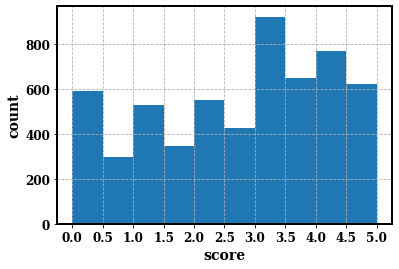

In [12]:

fig = plt.figure()
ax = fig.add_subplot(111)
hist = train_data['score'].hist(grid=False)

ax.set_xticks(np.arange(0,5.5,0.5),)
ax.grid(linestyle='--')

ax.set_xlabel('score', fontsize=14, weight='bold')
ax.set_ylabel('count', fontsize=14, weight='bold')

# plt.ylabel('count', fontsize=12)
# plt.xlabel()

plt.show()



## Dev data

In [13]:
dev_data.head()

,index,genre,filename,year,old_index,source1,source2,sentence1,sentence2,score
0,0,main-captions,MSRvid,2012test,0,none,none,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00
1,1,main-captions,MSRvid,2012test,2,none,none,A young child is riding a horse.,A child is riding a horse.,4.75
2,2,main-captions,MSRvid,2012test,3,none,none,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00
3,3,main-captions,MSRvid,2012test,7,none,none,A woman is playing the guitar.,A man is playing guitar.,2.40
4,4,main-captions,MSRvid,2012test,8,none,none,A woman is playing the flute.,A man is playing a flute.,2.75


In [14]:
print(dev_data.shape)

(1465, 10)


In [15]:
print(dev_data['score'].mean())
print(dev_data['score'].median())

2.3413406242879913
2.4


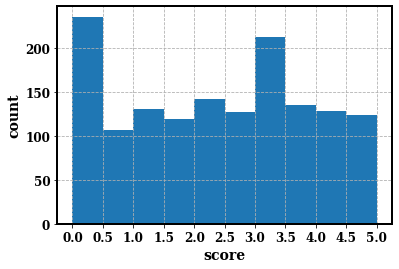

In [19]:

fig = plt.figure()
ax = fig.add_subplot(111)

dev_count = dev_data['score'].value_counts(bins=10, sort=False)
hist = dev_data['score'].hist(grid=False)
ax.set_xticks(np.arange(0,5.5,0.5),)
ax.grid(linestyle='--')

ax.set_xlabel('score', fontsize=14, weight='bold')
ax.set_ylabel('count', fontsize=14, weight='bold')

# plt.ylabel('count', fontsize=12)
# plt.xlabel()

plt.show()

## Test data

In [0]:
test_data.head()

In [0]:
test_data.shape

In [0]:
test_data['genre'].value_counts()

# Questions

* How is the test data evaluated without score in that?
